<a href="https://colab.research.google.com/github/DataBaeDev/nyc_property_sales/blob/main/NYC_Property_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1: Define the Problem

This analysis aims to answer the questions below using the [NYC Citywide Annualized Calendar Sales Update](https://data.cityofnewyork.us/City-Government/NYC-Citywide-Annualized-Calendar-Sales-Update/w2pb-icbu/about_data) dataset.

*  How accurately can one predict price using - gross sq. ft. & year built?

* Can the following features be used to identify in which borough a property sits: sale price, building class category, tax class at time of sale, and year built?

The dataset includes yearly sales information of properties sold in New York City from 2016-2022, and was last updated in July 2023 at the time of this analysis.

#Task 2: Install and Import Libraries

In [1]:
# install library needed to access NYC data
!pip install sodapy

In [2]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import plotly.express as px

from sodapy import Socrata

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configure Notebook

In [4]:
sns.set()

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

#Task 3: Load the Data

In [5]:
# Initialize the client, without using an api token
client = Socrata("data.cityofnewyork.us", None)
dataset_id = "w2pb-icbu" #NYC Citywide Annualized Calendar Sales

In [6]:
# Function to collect all records from the api and append to a dataframe
# Use an api token above to increase the number of records that can be obtained

def records_to_df(dataset_id):
    offset = 0
    limit = 50000
    records = []

    while True:
        results = client.get(dataset_id, limit=limit, offset=offset)
        if not results:
            break
        records.extend(results)
        offset += limit
        #print(f"{len(records)} records retrieved...")

    # Convert the list of records to a pandas DataFrame
    df = pd.DataFrame(records)
    return df

In [7]:
# Call function and save results to a dataframe
results_df = records_to_df(dataset_id)
results_df.head()

,borough,neighborhood,building_class_category,tax_class_as_of_final_roll,block,lot,building_class_as_of_final,address,zip_code,residential_units,commercial_units,total_units,land_square_feet,gross_square_feet,year_built,tax_class_at_time_of_sale,building_class_at_time_of,sale_price,sale_date,latitude,longitude,community_board,council_district,census_tract,bin,bbl,nta,apartment_number,census_tract_2020,nta_code
0,1,CHELSEA,21 OFFICE BUILDINGS,4,697,5,O2,555 WEST 25TH STREET,10001,0,8,8,"7,406","40,926",1926,4,O2,43300000.00,2019-03-28T00:00:00.000,40.749704,-74.00493,104,3,99,1012379,1006970005,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,NaN
1,1,CHELSEA,21 OFFICE BUILDINGS,4,697,23,O6,511 WEST 25TH STREET,10001,0,53,53,"9,890","83,612",1917,4,O6,148254147.00,2019-05-23T00:00:00.000,40.749364,-74.004132,104,3,99,1012382,1006970023,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,NaN
2,1,CHELSEA,21 OFFICE BUILDINGS,4,700,55,O2,538 WEST 29TH STREET,10001,1,3,4,"2,498","7,380",1910,4,O2,11000000.00,2019-03-13T00:00:00.000,40.752067,-74.002931,104,3,99,1012435,1007000055,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,NaN
3,1,CHELSEA,21 OFFICE BUILDINGS,4,712,1,O6,450 WEST 15TH,10011,0,30,30,"34,188","281,361",1936,4,O6,591800000.00,2019-05-22T00:00:00.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,CHELSEA,21 OFFICE BUILDINGS,4,746,64,O8,340 WEST 23RD STREET,10011,3,1,4,"2,469","5,603",1900,4,O8,0.00,2019-04-01T00:00:00.000,40.745809,-73.999729,104,3,93,1013367,1007460064,Hudson Yards-Chelsea-Flatiron-Union Square,NaN,NaN,NaN


# Task 4: Get Data Info

In [8]:
print(results_df.shape)
results_df.info()

(606260, 30)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606260 entries, 0 to 606259
Data columns (total 30 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   borough                     606260 non-null  object
 1   neighborhood                606260 non-null  object
 2   building_class_category     606260 non-null  object
 3   tax_class_as_of_final_roll  602077 non-null  object
 4   block                       606260 non-null  object
 5   lot                         606260 non-null  object
 6   building_class_as_of_final  602077 non-null  object
 7   address                     606260 non-null  object
 8   zip_code                    606226 non-null  object
 9   residential_units           530726 non-null  object
 10  commercial_units            493870 non-null  object
 11  total_units                 536746 non-null  object
 12  land_square_feet            487848 non-null  object
 13  gross_square_fee

- Identify columns that are missing too many values

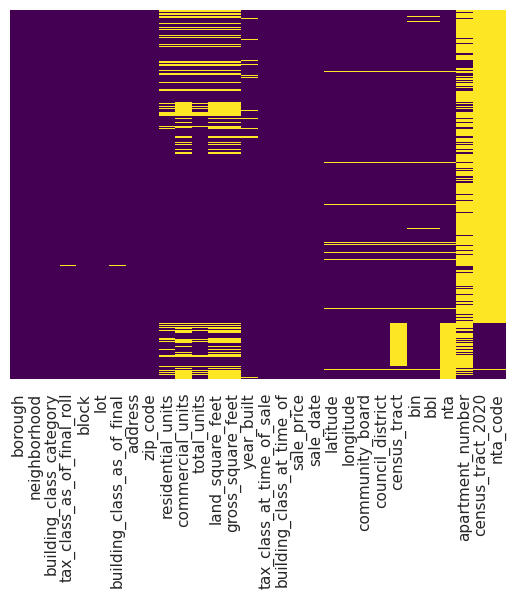

In [9]:
sns.heatmap(results_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis');

## Task 5: Data Cleaning and Manipulation

- Drop unneeded columns

In [10]:
results_df = results_df.drop(columns=['block', 'lot', 'building_class_as_of_final',  'address', 'zip_code',
                                      'latitude', 'longitude', 'community_board', 'council_district', 'census_tract',
                                      'apartment_number',  'census_tract_2020',  'nta_code', 'nta', 'land_square_feet',
                                      'residential_units', 'commercial_units'])

*   Convert "Sales Date" column from object to date type

In [11]:
results_df['sale_date'] = pd.to_datetime(results_df['sale_date']).dt.normalize()

- Convert "borough" column to text category values

In [12]:
# original values in the borough column
results_df.borough.unique()

array(['1', 'MANHATTAN', '2', '3', '4', '5', 'BRONX', 'BROOKLYN',
       'QUEENS', 'STATEN ISLAND'], dtype=object)

In [13]:
borough_map = {
    '1': 'Manhattan',
    '2': 'Bronx',
    '3': 'Brooklyn',
    '4': 'Queens',
    '5': 'Staten Island',
    'MANHATTAN': 'Manhattan',
    'BRONX': 'Bronx',
    'BROOKLYN': 'Brooklyn' ,
    'QUEENS' : 'Queens',
    'STATEN ISLAND': 'Staten Island'
}

results_df['borough'] = results_df['borough'].map(borough_map).astype('category')

In [14]:
#updated column values
results_df.borough.unique()

['Manhattan', 'Bronx', 'Brooklyn', 'Queens', 'Staten Island']
Categories (5, object): ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']

- convert integer columns

In [15]:
int_cols = ['total_units', 'year_built','sale_price', 'gross_square_feet']

results_df[int_cols] = results_df[int_cols].apply(pd.to_numeric, errors='coerce').astype('Int64')

- create "Sales Year" Column

In [16]:
results_df['Sale_Yr'] = results_df['sale_date'].dt.year

## Task 6: EDA

In [17]:
results_df.describe()

,total_units,gross_square_feet,year_built,sale_price,sale_date,Sale_Yr
count,536746.0,121982.0,582735.0,606260.0,606260,606260.000000
mean,2.657946,2457.673075,1870.954389,1301782.630787,2019-07-13 20:47:44.846105856,2019.027422
min,0.0,0.0,0.0,0.0,2016-01-01 00:00:00,2016.000000
25%,1.0,0.0,1920.0,0.0,2017-09-13 00:00:00,2017.000000
50%,1.0,596.0,1941.0,465000.0,2019-06-28 00:00:00,2019.000000
75%,2.0,1470.0,1970.0,900000.0,2021-06-15 00:00:00,2021.000000
max,8812.0,8942176.0,2022.0,2397501899.0,2022-12-31 00:00:00,2022.000000
std,22.439695,41439.638438,388.72395,11555884.690926,NaN,2.051731


In [18]:
print("Number of Unique Values Per Text Column")
for col in results_df.dtypes[results_df.dtypes == object].index:
  print(f"{col}: {results_df[col].nunique()} unique values")

Number of Unique Values Per Text Column
neighborhood: 261 unique values
building_class_category: 91 unique values
tax_class_as_of_final_roll: 11 unique values
tax_class_at_time_of_sale: 4 unique values
building_class_at_time_of: 196 unique values
bin: 273799 unique values
bbl: 266451 unique values


In [19]:
results_df.tax_class_as_of_final_roll.unique()

array(['4', '1', '2', '2C', '2A', '2B', '1C', nan, '1A', '1B', '1D', '3'],
      dtype=object)

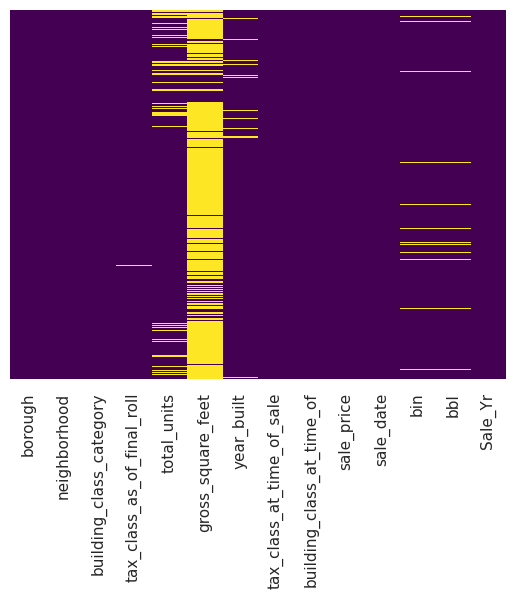

In [20]:
sns.heatmap(results_df.isnull(), yticklabels = False, cbar = False, cmap = 'viridis');

In [21]:
print("Sale Date Range", results_df['sale_date'].min(), "-", results_df['sale_date'].max())

Sale Date Range 2016-01-01 00:00:00 - 2022-12-31 00:00:00


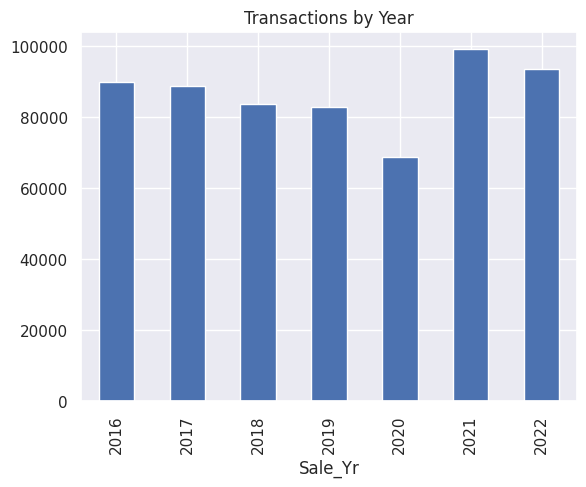

In [22]:
results_df['Sale_Yr'].value_counts().sort_index().plot(kind='bar', title='Transactions by Year');

In [55]:
#Use the BBL (Borough, Block, & Lot) and the BIN (Building ID Number) to identify distinct properties by year built
distinct_properties = results_df[['year_built', 'bin', 'bbl', 'building_class_category', 'neighborhood', 'borough']]

# eliminate properties without identifiers and duplicates
distinct_properties = distinct_properties.dropna(how='any')
distinct_properties = distinct_properties.drop_duplicates()

In [37]:
#discard properties built before 1895

distinct_properties = distinct_properties[distinct_properties.year_built >= 1895]

In [38]:
len(distinct_properties)

297597

Earliest Property Built:  1895
Newest Property Built:  2022


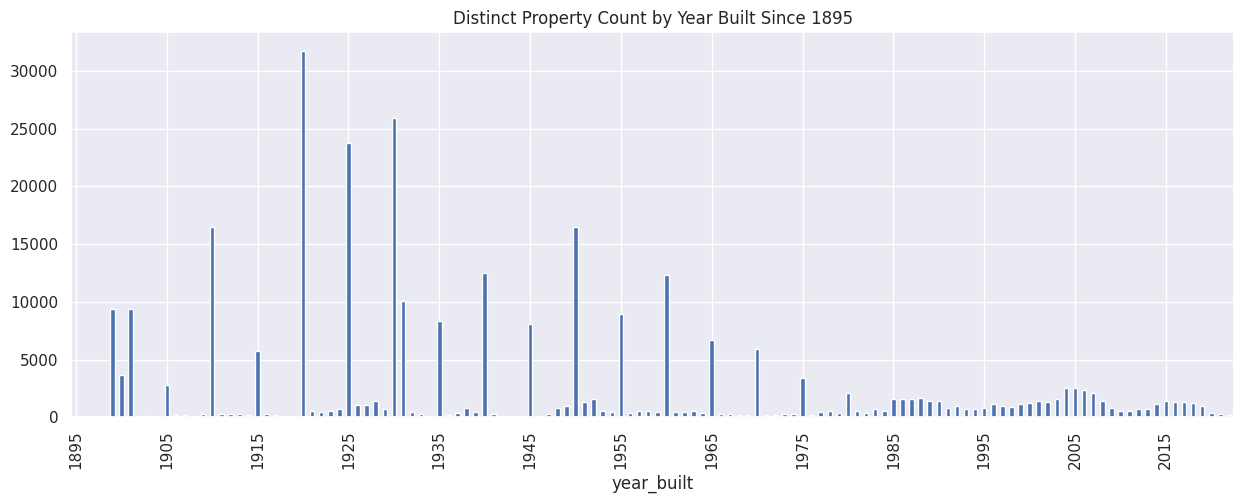

In [42]:
properties = distinct_properties['year_built'].value_counts().sort_index()

print("Earliest Property Built: ", properties.index.min())
print("Newest Property Built: ", properties.index.max())

ax = properties.plot(kind='bar', title='Distinct Property Count by Year Built Since 1895', figsize = (15, 5))

# Set the x tick labels to display every 10th label
ax.set_xticks(range(0, len(properties), 10))
plt.show();

In [56]:
# tree map for neighborhood
word_count_tree = px.treemap(distinct_properties, path=["borough"], title="Proportion of Disinct Properties Sold by Borough")
word_count_tree.update_traces(marker=dict(cornerradius=3))
word_count_tree.update_layout(
    treemapcolorway = ["blue", "dodgerblue", "cornflowerblue"],
    uniformtext_minsize=8, uniformtext_mode='hide',
    margin = dict(t=50, l=25, r=25, b=25)
)
word_count_tree.data[0].textinfo = 'label+value'
word_count_tree.show()

In [53]:
# tree map for building class
word_count_tree = px.treemap(distinct_properties, path=["building_class_category"], title="Proportional View of Distinct Properties Sold by Building Class")
word_count_tree.update_traces(marker=dict(cornerradius=3))
word_count_tree.update_layout(
    treemapcolorway = ["blue", "dodgerblue", "cornflowerblue"],
    uniformtext_minsize=8, uniformtext_mode='hide',
    margin = dict(t=50, l=25, r=25, b=25)
)
word_count_tree.data[0].textinfo = 'label+value'
word_count_tree.show()

#Task 7: Conceptualize Question 1 & Train Model

How accurately can one predict the sales price using - gross square footage & year built?

In [45]:
#Select features for regression model
price_pred_df = results_df[['year_built', 'gross_square_feet', 'sale_price']]

#drop nulls
price_pred_df = price_pred_df.dropna(how='any')

#exclude properties sold for $0, indicates a transfer of ownership without a cash consideration
price_pred_df = price_pred_df[price_pred_df['sale_price']>0]

#check to see how many nulls there are
print(price_pred_df.shape)
price_pred_df.isna().sum()

(75654, 3)


year_built           0
gross_square_feet    0
sale_price           0
dtype: int64

In [46]:
# Change X into 2D array
X = price_pred_df.drop(columns=['sale_price'])
y = price_pred_df['sale_price']

#perform data split and train model
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, random_state = 16)
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [47]:
#Use Mean Squared Error and R-squared rate each model (test)
predictions = model.predict(x_test)

mse = metrics.mean_squared_error(y_test, predictions)
r2 = metrics.r2_score(y_test, predictions)
print(f"The Mean Squared Error is {round(mse, 2)}")
print(f"The R squared score is {round(r2,2) }.")

#Save the model
# pickle.dump(model, open(f'/content/drive/MyDrive/Predictive Analytics/NYC Property Sales/nyc_LinearReg.pkl','wb'))

The Mean Squared Error is 168357680056771.0
The R squared score is 0.01.


                   year_built  gross_square_feet  sale_price
year_built           1.000000            0.01084   -0.002937
gross_square_feet    0.010840            1.00000    0.077200
sale_price          -0.002937            0.07720    1.000000


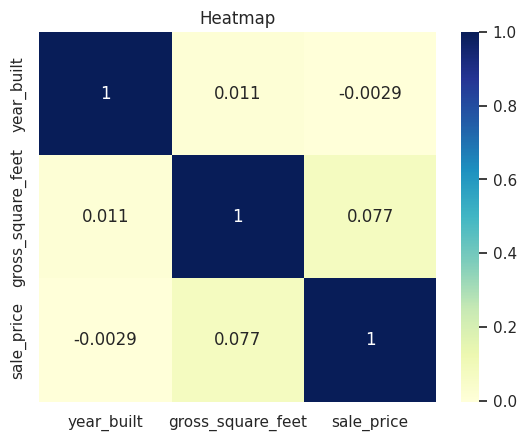

In [48]:
print(price_pred_df.corr())
sns.heatmap(price_pred_df.corr(), cmap="YlGnBu", annot=True).set(title="Heatmap");

## Question 1 Findings<br>
There is not a linear relationship between the year built, gross square feet and the sale price

#Task 8: Conceptualize Question 2
Can the following features be used to identify in which borough a property sits: sale price, building class category, tax class at time of sale, and year built?

Since the data is labeled, the following classification models will be trained and checked for accuracy:
*   Decision Tree Classifier
*   Random Forest Classifier
*   KNN Classifier

In [60]:
#select features & target
class_df = results_df[['sale_price','borough','building_class_category', 'tax_class_at_time_of_sale', 'year_built']]

#exclude properties sold for $0, indicates a transfer of ownership without a cash consideration
class_df = class_df[class_df['sale_price']>0]

#discard properties built before 1895, these are outliers
class_df = class_df[class_df.year_built >= 1895]

#drop nulls
class_df = class_df.dropna(how='any')

#convert remaining columns to boolean values
class_df = pd.get_dummies(class_df, drop_first=True, prefix=['bcc_', 'tc_'], columns=['building_class_category', 'tax_class_at_time_of_sale'])
class_df.head()


,sale_price,borough,year_built,bcc__01 ONE FAMILY DWELLINGS,bcc__02 TWO FAMILY DWELLINGS,bcc__02 TWO FAMILY DWELLINGS,bcc__03 THREE FAMILY DWELLINGS,bcc__03 THREE FAMILY DWELLINGS,bcc__04 TAX CLASS 1 CONDOS,bcc__04 TAX CLASS 1 CONDOS,bcc__05 TAX CLASS 1 VACANT LAND,bcc__05 TAX CLASS 1 VACANT LAND,bcc__06 TAX CLASS 1 - OTHER,bcc__06 TAX CLASS 1 - OTHER,bcc__07 RENTALS - WALKUP APARTMENTS,bcc__07 RENTALS - WALKUP APARTMENTS,bcc__08 RENTALS - ELEVATOR APARTMENTS,bcc__08 RENTALS - ELEVATOR APARTMENTS,bcc__09 COOPS - WALKUP APARTMENTS,bcc__09 COOPS - WALKUP APARTMENTS,bcc__10 COOPS - ELEVATOR APARTMENTS,bcc__10 COOPS - ELEVATOR APARTMENTS,bcc__11 SPECIAL CONDO BILLING LOTS,bcc__11 SPECIAL CONDO BILLING LOTS,bcc__11A CONDO-RENTALS,bcc__12 CONDOS - WALKUP APARTMENTS,bcc__12 CONDOS - WALKUP APARTMENTS,bcc__13 CONDOS - ELEVATOR APARTMENTS,bcc__13 CONDOS - ELEVATOR APARTMENTS,bcc__14 RENTALS - 4-10 UNIT,bcc__14 RENTALS - 4-10 UNIT,bcc__15 CONDOS - 2-10 UNIT RESIDENTIAL,bcc__15 CONDOS - 2-10 UNIT RESIDENTIAL,bcc__16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,bcc__16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,bcc__17 CONDO COOPS,bcc__17 CONDO COOPS,bcc__21 OFFICE BUILDINGS,bcc__21 OFFICE BUILDINGS,bcc__22 STORE BUILDINGS,bcc__22 STORE BUILDINGS,bcc__23 LOFT BUILDINGS,bcc__23 LOFT BUILDINGS,bcc__25 LUXURY HOTELS,bcc__25 LUXURY HOTELS,bcc__26 OTHER HOTELS,bcc__26 OTHER HOTELS,bcc__27 FACTORIES,bcc__27 FACTORIES,bcc__28 COMMERCIAL CONDOS,bcc__28 COMMERCIAL CONDOS,bcc__29 COMMERCIAL GARAGES,bcc__29 COMMERCIAL GARAGES,bcc__30 WAREHOUSES,bcc__30 WAREHOUSES,bcc__31 COMMERCIAL VACANT LAND,bcc__31 COMMERCIAL VACANT LAND,bcc__32 HOSPITAL AND HEALTH FACILITIES,bcc__32 HOSPITAL AND HEALTH FACILITIES,bcc__33 EDUCATIONAL FACILITIES,bcc__33 EDUCATIONAL FACILITIES,bcc__34 THEATRES,bcc__34 THEATRES,bcc__35 INDOOR PUBLIC AND CULTURAL FACILITIES,bcc__35 INDOOR PUBLIC AND CULTURAL FACILITIES,bcc__36 OUTDOOR RECREATIONAL FACILITIES,bcc__36 OUTDOOR RECREATIONAL FACILITIES,bcc__37 RELIGIOUS FACILITIES,bcc__37 RELIGIOUS FACILITIES,bcc__38 ASYLUMS AND HOMES,bcc__38 ASYLUMS AND HOMES,bcc__39 TRANSPORTATION FACILITIES,bcc__39 TRANSPORTATION FACILITIES,bcc__40 SELECTED GOVERNMENTAL FACILITIES,bcc__41 TAX CLASS 4 - OTHER,bcc__41 TAX CLASS 4 - OTHER,bcc__42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,bcc__42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,bcc__43 CONDO OFFICE BUILDINGS,bcc__43 CONDO OFFICE BUILDINGS,bcc__44 CONDO PARKING,bcc__44 CONDO PARKING,bcc__45 CONDO HOTELS,bcc__45 CONDO HOTELS,bcc__46 CONDO STORE BUILDINGS,bcc__46 CONDO STORE BUILDINGS,bcc__47 CONDO NON-BUSINESS STORAGE,bcc__47 CONDO NON-BUSINESS STORAGE,bcc__48 CONDO TERRACES/GARDENS/CABANAS,bcc__48 CONDO TERRACES/GARDENS/CABANAS,bcc__49 CONDO WAREHOUSES/FACTORY/INDUS,bcc__49 CONDO WAREHOUSES/FACTORY/INDUS,tc__2,tc__4
0,43300000,Manhattan,1926,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,148254147,Manhattan,1917,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,11000000,Manhattan,1910,False,False,False,False,False,False,False,False,Fal

In [64]:
X = class_df.drop(columns=['borough'])
y =  class_df['borough']

In [65]:
# perform data split
x_train, x_test, y_train, y_test = train_test_split(X,y,  test_size = 0.20, random_state = 22)

In [66]:
#Select models, and train each
Decision_Tree_Classifier  = DecisionTreeClassifier()
Random_Forest_Classifier  = RandomForestClassifier()
K_Nearest_Neighbors_Classifier = KNeighborsClassifier()

In [67]:
models = [Decision_Tree_Classifier, Random_Forest_Classifier, K_Nearest_Neighbors_Classifier]

for clf in models:
  clf.fit(x_train, y_train)
  predictions = clf.predict(x_test)
  print(f"{clf} Accuracy Score:",metrics.accuracy_score(y_test, predictions))
  pickle.dump(clf, open(f'/content/drive/MyDrive/Predictive Analytics/NYC Property Sales/NYC_{clf}.pkl','wb'))

DecisionTreeClassifier() Accuracy Score: 0.6252830572729817
RandomForestClassifier() Accuracy Score: 0.640180138920693
KNeighborsClassifier() Accuracy Score: 0.5280258504439864


## Question 2 Findings<br>
Overall, the combination of the selected feature (sale price, building class category, tax_class_at_time_of_sale, and year built) do not provide enough information to accurately identify which neighborhood a property belongs to.


The Decision Tree Classifier and the Random Forest Classifier both consistently perform better than the K Nearest Neighbors model, even after making several adjustments to k.

## Additional Notes

Unfortunately the original dataset contains a lot of missing values that pertain to the number of units or the square footage of the property. It seems feasible that the existence of these missing values would help the models peform more accurately.

This analysis used only one geographic feature (borough). In order to prevent multicollinearity, other geographic indicators such as neighborhood and zip code were intentionally excluded.

## Next Steps
Potential next steps for this analysis would be

1) Check to see if the models' performance improves when isolating property sales by year

2) Determine if the number of times a property was sold from 2016-2022 is an indicator of which borough the property might be in

## Resources:
*   https://www.nyc.gov/assets/finance/jump/hlpbldgcode.html
*   https://www.nyc.gov/assets/finance/downloads/pdf/07pdf/glossary_rsf071607.pdf
